In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt


In [129]:
def plot(df,name):
    # Your data
    column_name_probability = ['ProbabilityScalarArithmetic',
        'ProbabilityScalarLogic',
        'ProbabilityScalarMemory',
        'ProbabilityScalarBranch',
        'ProbabilityScalarJump',
        'ProbabilityVectorArithmetic',
        'ProbabilityVectorLogic',
        'ProbabilityVectorMemory',
        'ProbabilityVectorBranch',
        'ProbabilityVectorJump']
    column_name_probability_labels = ['ScalarArithmetic',
        'ScalarLogic',
        'ScalarMemory',
        'ScalarBranch',
        'ScalarJump',
        'VecArithmetic',
        'VecLogic',
        'VecMemory',
        'VecBranch',
        'VecJump']
    plt.figure(figsize=(14,14))

    plt.subplot(2, 2, 1)

    plt.title(name)
    x=range(0,len(column_name_probability))
    
    plt.bar(x=x,height=df[column_name_probability].mean(),alpha=0.3)
    plt.errorbar(x,df[column_name_probability].mean(),yerr=df[column_name_probability].std(), fmt='o')
    #.plot(kind='bar', width=0.8) # Plot bar chart
    #plt.title("ksad") # Set title as column name
    #plt.xlabel(column) # Set x-axis label as column name
    plt.xticks(ticks=x,labels=column_name_probability_labels,rotation=90-15,fontsize=8)
    #plt.xticks(ticks=range(0,len(column_name)),labels=column,rotation=45)
    plt.ylabel('Value') # Set y-axis label as 'Value'
    column_name=["SocketPower0", "SocketPower1","PSUPower0","PSUPower1"]
    plt.subplot(2, 2, 2)
    
    _ = plt.plot(df[column_name],label=column_name)
    plt.ylim([0,450])
    plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(df[column_name_probability],label=column_name_probability)
    plt.legend()
   # plt.ylim([0,150])
    plt.subplot(2, 2, 4)
    plt.title("System usage")
    plt.plot(df[["SystemCpuUsage" ,"ProcessCpuUsage"]],label=["SystemCpuUsage" ,"ProcessCpuUsage"])
    plt.legend()
    plt.savefig(f"{name}.png")

Opened file: power_copy.csv
Opened file: power_copy_mem.csv
Opened file: power_copy_mem_avx.csv
Opened file: power_daxpy_mem_avx_fma.csv
lol
Opened file: power_load_mem.csv
lol
Opened file: power_stream_mem_avx_fma.csv
Opened file: power_update_avx.csv


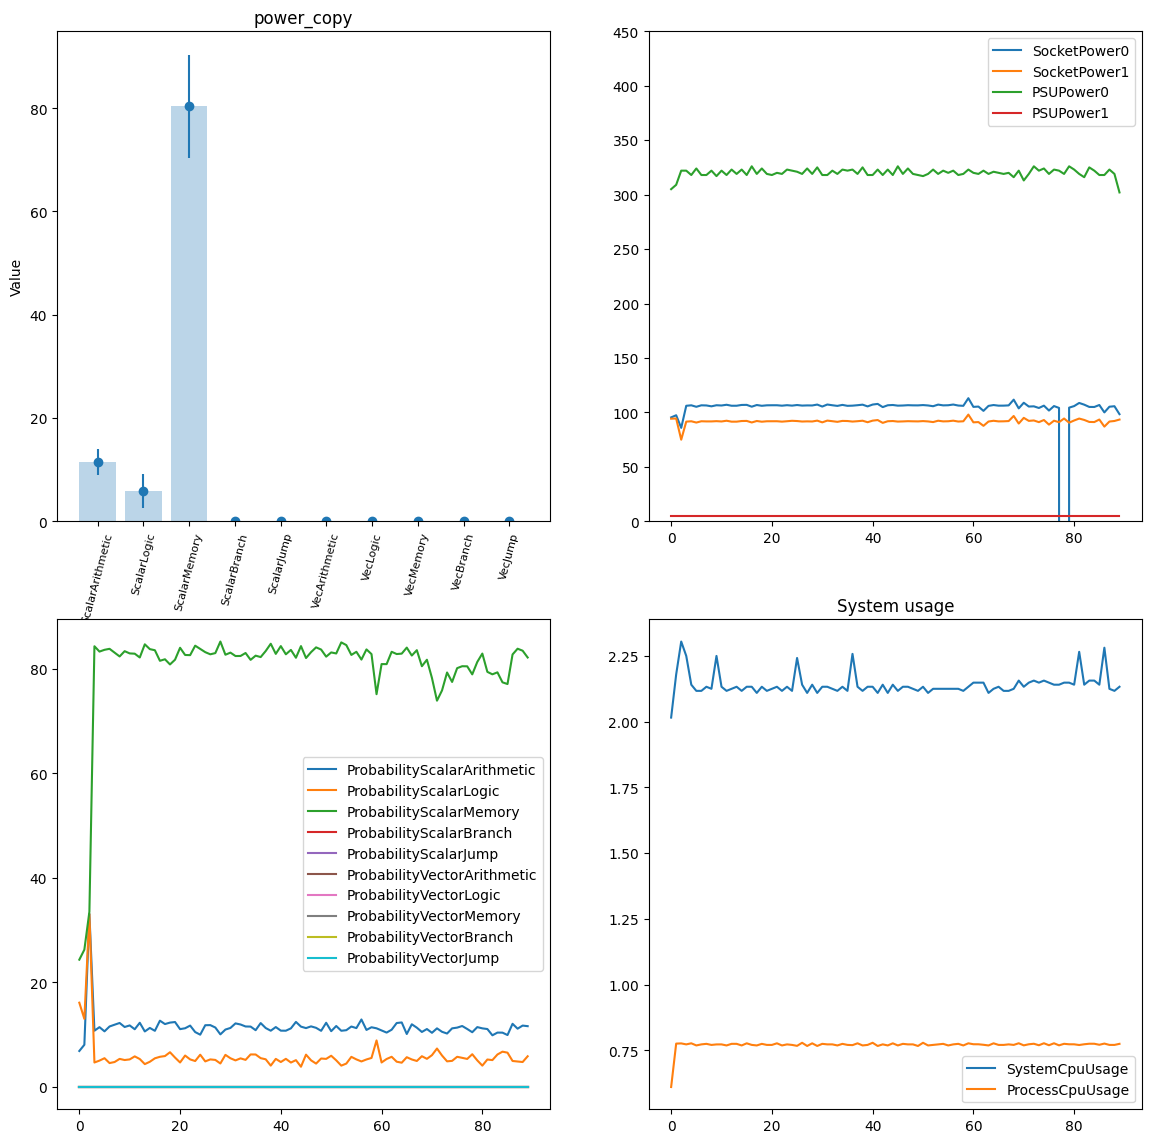

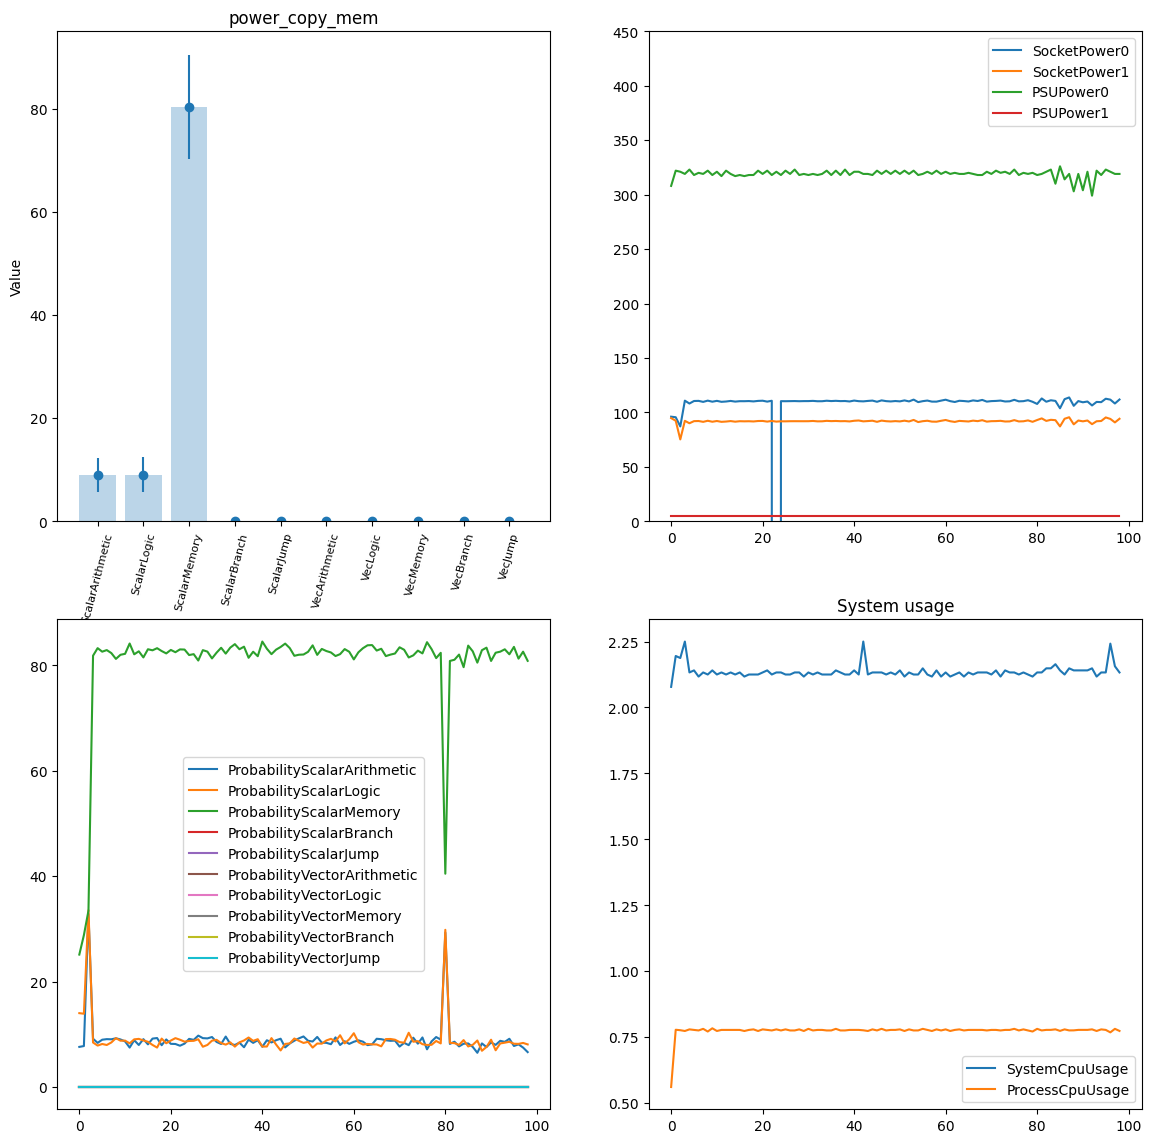

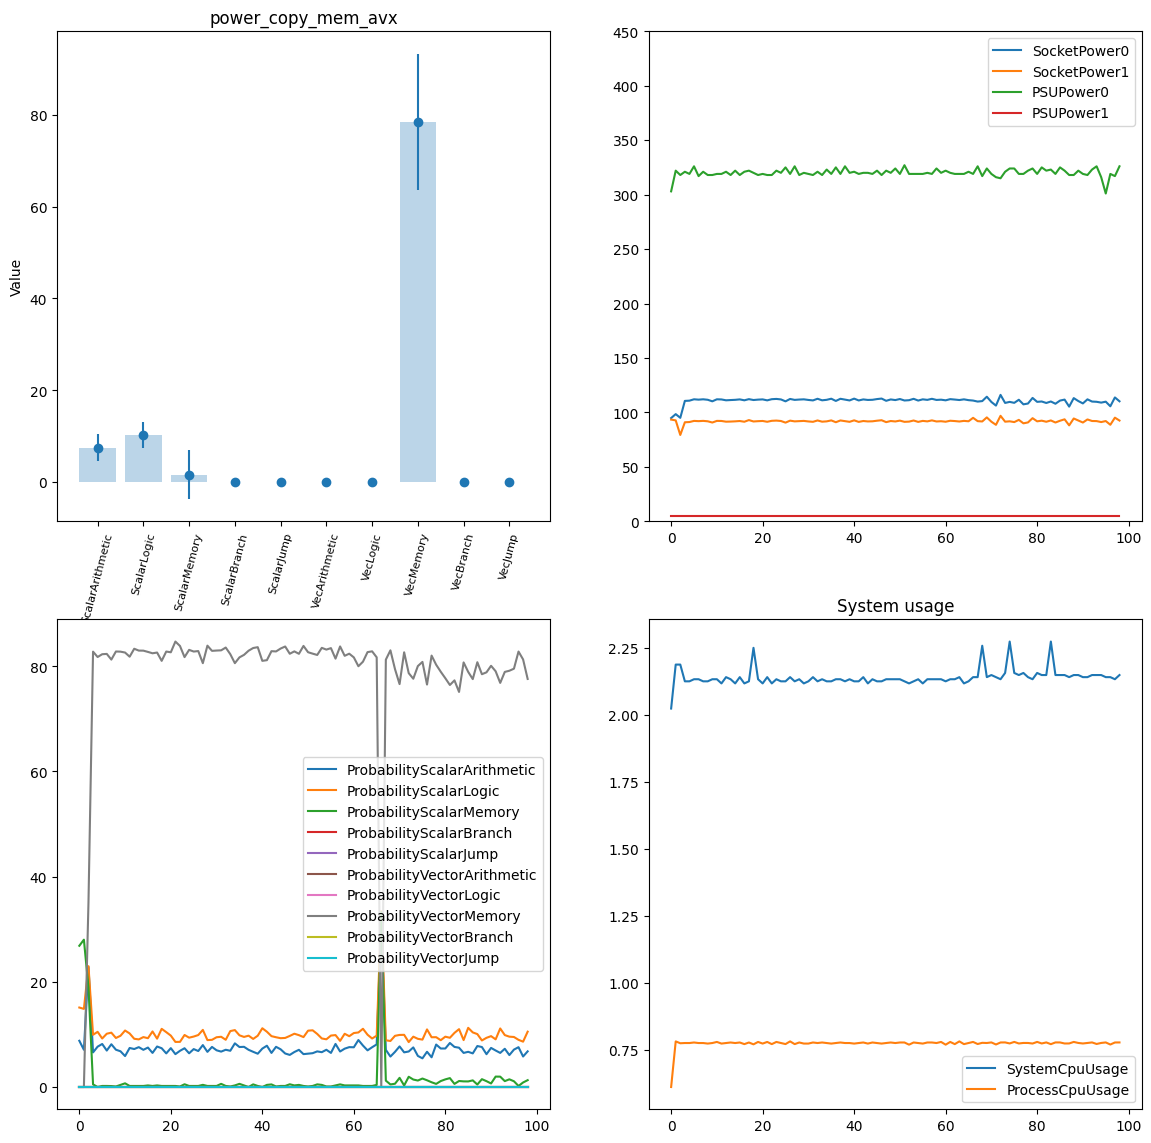

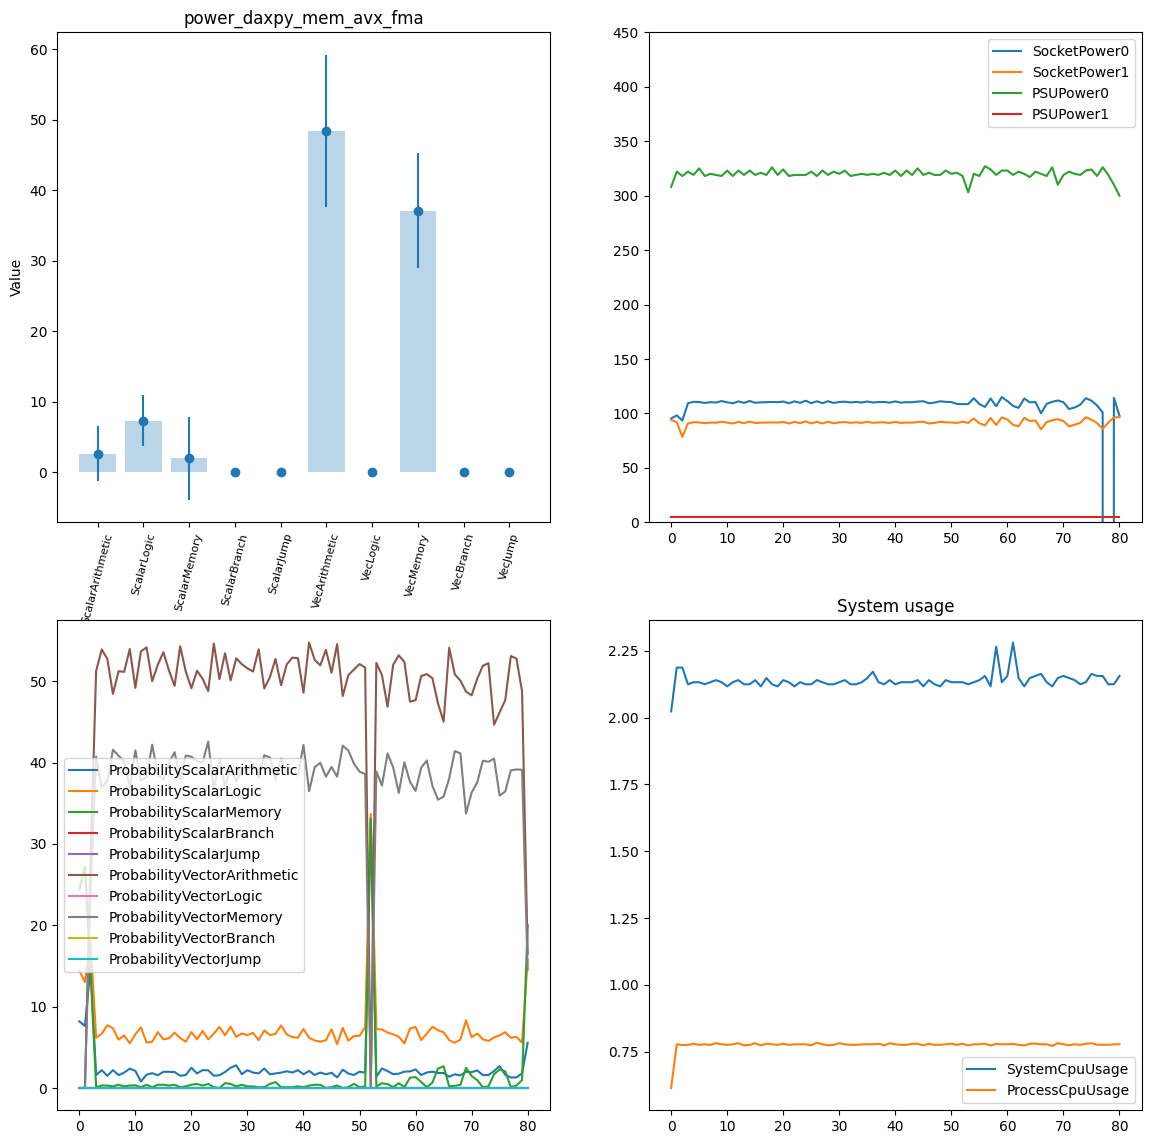

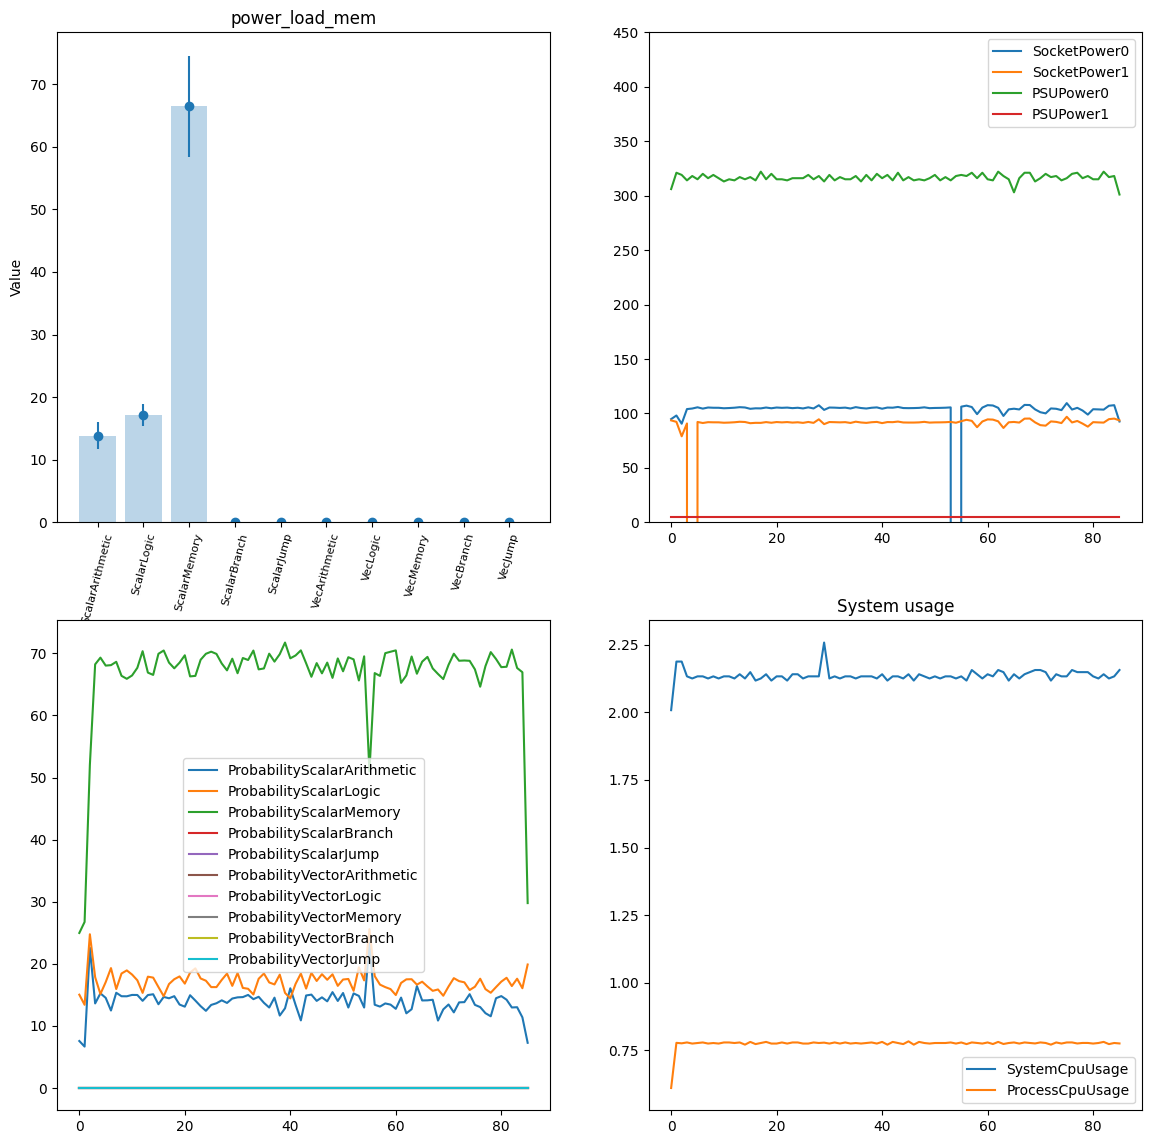

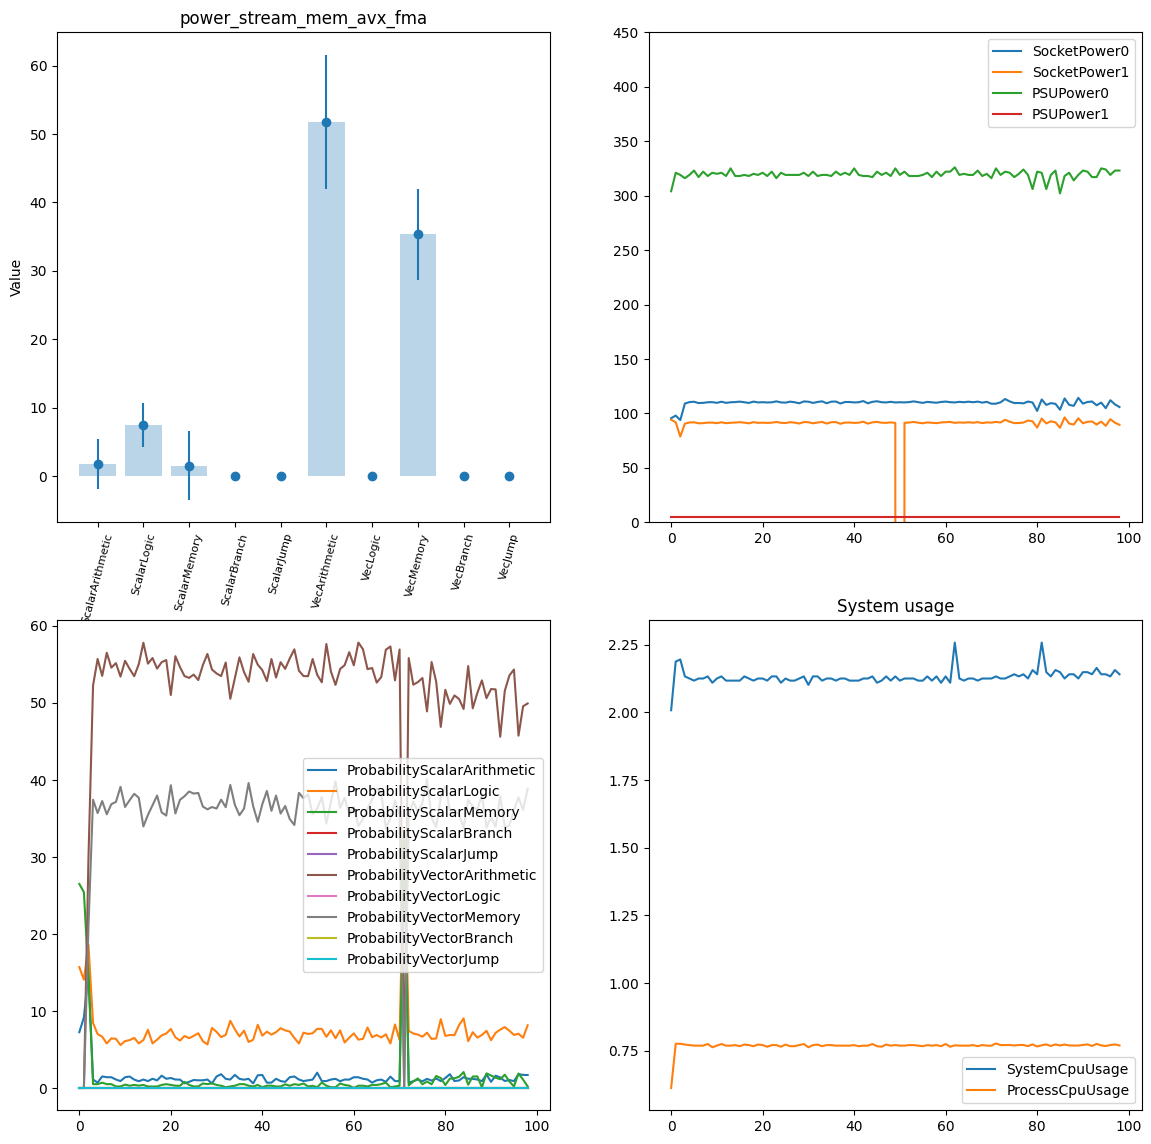

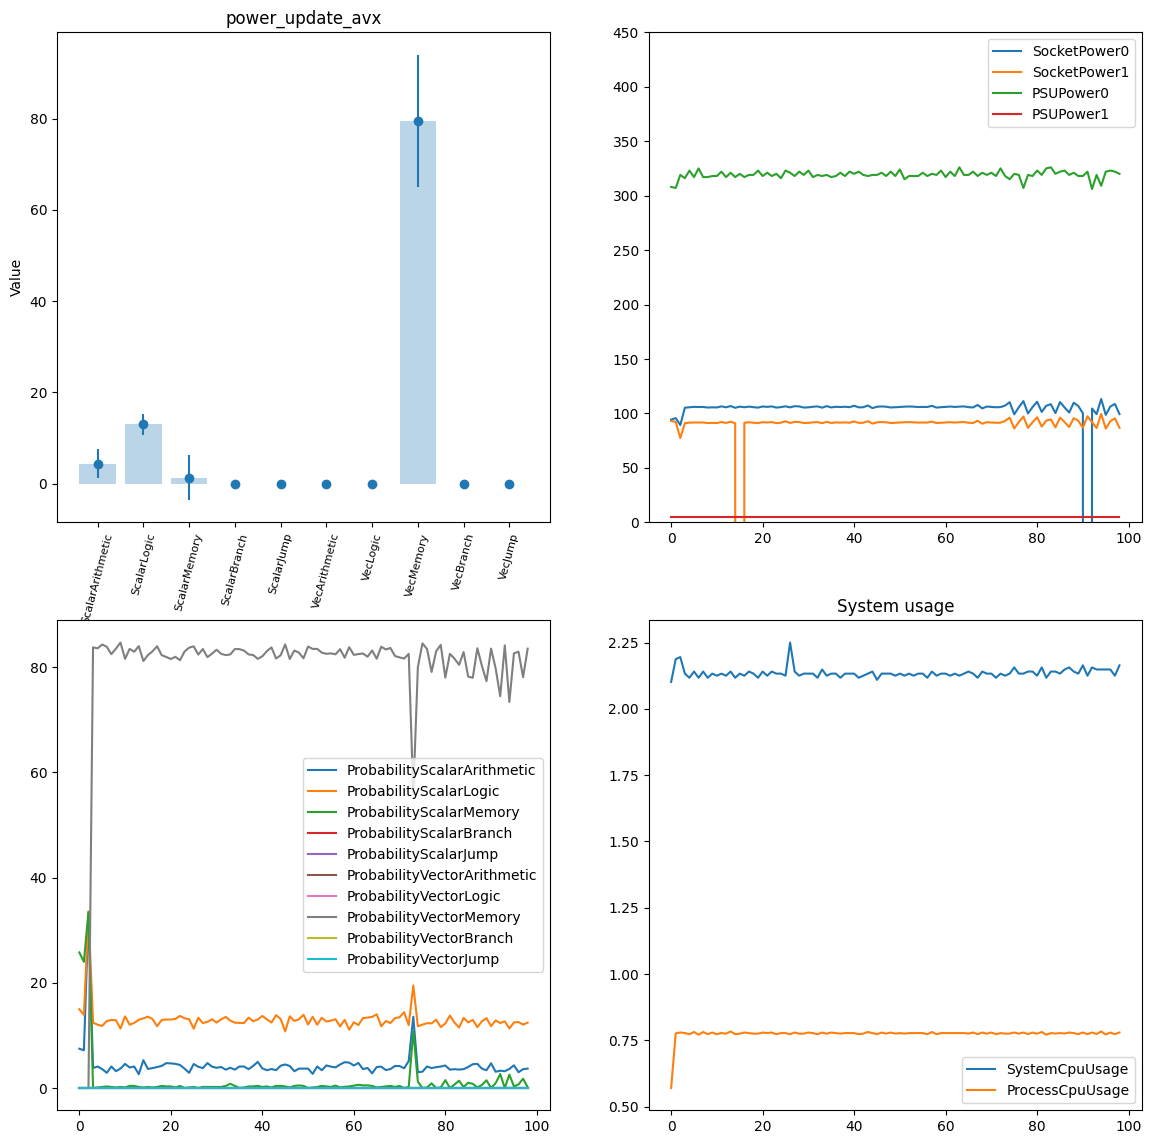

In [130]:
for filename in os.listdir("results"):
    if filename.endswith(".csv"):
        try:
            df = pd.read_csv(os.path.join("results", filename))
            print(f"Opened file: {filename}")
            #print(df.head())  # prints the first 5 rows of each CSV file
            plot(df,os.path.basename(filename).split(".")[0])
        except:
            print("lol")

In [81]:
 df = pd.read_csv("results/power_copy.csv")

In [82]:
df

,Timestamp,SocketPower0,SocketPower1,ProbabilityScalarArithmetic,ProbabilityScalarLogic,ProbabilityScalarMemory,ProbabilityScalarBranch,ProbabilityScalarJump,ProbabilityVectorArithmetic,ProbabilityVectorLogic,ProbabilityVectorMemory,ProbabilityVectorBranch,ProbabilityVectorJump,PSUPower0,PSUPower1,SystemCpuUsage,ProcessCpuUsage,TimeDifference
0,179718760,95.4021,94.1998,6.89,16.13,24.36,0,0,0,0,0,0,0,305,5,2.01562,0.611023,4360
1,179722220,97.3763,94.4031,8.08,13.03,26.27,0,0,0,0,0,0,0,309,5,2.17969,0.776018,3460
2,179725740,85.7766,74.9331,33.09,33.08,33.53,0,0,0,0,0,0,0,322,5,2.30469,0.776811,3520
3,179729580,106.0590,91.5202,10.77,4.69,84.32,0,0,0,0,0,0,0,322,5,2.25000,0.773055,3840
4,179733420,106.5000,91.8360,11.45,5.05,83.30,0,0,0,0,0,0,0,318,5,2.14062,0.777160,3840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,180042460,106.7860,93.4300,9.94,6.57,77.09,0,0,0,0,0,0,0,318,5,2.14062,0.771581,3040
86,180046520,99.9887,86.9343,12.09,4.98,82.75,0,0,0,0,0,0,0,318,5,2.28125,0.776144,4060
87,180050340,105.2060,91.5985,11.16,4.88,83.85,0,0,0,0,0,0,0,323,5,2.12500,0.771078,3820
88,180054180,105.6650,92.1082,11.75,4.78,83.47,0,0,0,0,0,0,0,319,5,2.11719,0.771024,3840
